In [19]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data import DataLoader as dataloader
from datasets import load_dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pytorch_fid import fid_score
from torchvision.utils import save_image
import torch.nn.functional as F
import torchvision.utils as vutils
import random

In [20]:
device='cuda'

In [21]:


import torch
from torch import nn
from torch.nn import functional as F


class VAE(nn.Module):
    def __init__(self, zsize, layer_count=3, channels=3):
        super(VAE, self).__init__()

        d = 128
        self.d = d
        self.zsize = zsize

        self.layer_count = layer_count

        mul = 1
        inputs = channels
        for i in range(self.layer_count):
            setattr(self, "conv%d" % (i + 1), nn.Conv2d(inputs, d * mul, 4, 2, 1))
            setattr(self, "conv%d_bn" % (i + 1), nn.BatchNorm2d(d * mul))
            inputs = d * mul
            mul *= 2

        self.d_max = inputs

        self.fc1 = nn.Linear(inputs * 4 * 4, zsize)
        self.fc2 = nn.Linear(inputs * 4 * 4, zsize)

        self.d1 = nn.Linear(zsize, inputs * 4 * 4)

        mul = inputs // d // 2

        for i in range(1, self.layer_count):
            setattr(self, "deconv%d" % (i + 1), nn.ConvTranspose2d(inputs, d * mul, 4, 2, 1))
            setattr(self, "deconv%d_bn" % (i + 1), nn.BatchNorm2d(d * mul))
            inputs = d * mul
            mul //= 2

        setattr(self, "deconv%d" % (self.layer_count + 1), nn.ConvTranspose2d(inputs, channels, 4, 2, 1))

    def encode(self, x):
        for i in range(self.layer_count):
            x = F.relu(getattr(self, "conv%d_bn" % (i + 1))(getattr(self, "conv%d" % (i + 1))(x)))

        x = x.view(x.shape[0], self.d_max * 4 * 4)
        h1 = self.fc1(x)
        h2 = self.fc2(x)
        return h1, h2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, x):
        x = x.view(x.shape[0], self.zsize)
        x = self.d1(x)
        x = x.view(x.shape[0], self.d_max, 4, 4)
        #x = self.deconv1_bn(x)
        x = F.leaky_relu(x, 0.2)

        for i in range(1, self.layer_count):
            x = F.leaky_relu(getattr(self, "deconv%d_bn" % (i + 1))(getattr(self, "deconv%d" % (i + 1))(x)), 0.2)

        x = F.tanh(getattr(self, "deconv%d" % (self.layer_count + 1))(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        mu = mu.squeeze()
        logvar = logvar.squeeze()
        z = self.reparameterize(mu, logvar)
        return self.decode(z.view(-1, self.zsize, 1, 1)), mu, logvar

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)


def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()


In [22]:
import torch
from torchvision.utils import save_image
from pathlib import Path
from pytorch_fid import fid_score
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Load the VAE model
z_size = 512
vae = VAE(zsize=z_size, layer_count=5)
vae.load_state_dict(torch.load("VAEmodel_butterfly.pkl"))
vae.cuda()
vae.eval()

# Directory paths
generated_images_dir = "./generated_images"
real_images_dir = "/home/sriyar/ADRL_Assignment2/butterflies_data/2/train"  # Use train images for FID comparison

# Create a directory for generated images
Path(generated_images_dir).mkdir(parents=True, exist_ok=True)

# Generate and save 1000 images
num_images = 1000
batch_size = 64  # Adjust this batch size if needed
n_batches = num_images // batch_size

with torch.no_grad():
    for i in range(n_batches):
        # Generate a batch of latent vectors
        sample_z = torch.randn(batch_size, z_size).view(-1, z_size, 1, 1).cuda()
        
        # Generate images from the latent vectors
        generated_images = vae.decode(sample_z)
        
        # Save generated images
        for j, img in enumerate(generated_images):
            save_image(img * 0.5 + 0.5, f"{generated_images_dir}/img_{i*batch_size + j}.png")  # Scale to [0, 1]

print("Generated images saved. Now calculating FID...")

# Calculate FID between generated images and real images
fid_value = fid_score.calculate_fid_given_paths([generated_images_dir, real_images_dir], batch_size=50, device='cuda', dims=2048)
print("FID Score:", fid_value)


/tmp/ipykernel_3357361/2827874614.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("VAEmodel_butterfly.pkl"))


Generated images saved. Now calculating FID...


100%|██████████| 130/130 [00:13<00:00,  9.36it/s]


FID Score: 281.8417229984206


In [23]:
import torch
from torchvision.utils import save_image
from pathlib import Path
from pytorch_fid import fid_score

# Load the VAE model for animals
z_size = 512
vae_animals = VAE(zsize=z_size, layer_count=5)
vae_animals.load_state_dict(torch.load("/home/sriyar/ADRL_Assignment2/VAEmodel_animals_24_10.pkl"))
vae_animals.cuda()
vae_animals.eval()

# Directory paths
generated_images_dir = "./generated_images_animals"
real_images_dir = "/home/sriyar/ADRL_Assignment2/Animals_data/animals"  # Path to real animal images

# Create a directory for generated images
Path(generated_images_dir).mkdir(parents=True, exist_ok=True)

# Generate and save 1000 images
num_images = 1000
batch_size = 64
n_batches = num_images // batch_size

with torch.no_grad():
    for i in range(n_batches):
        # Generate a batch of latent vectors
        sample_z = torch.randn(batch_size, z_size).view(-1, z_size, 1, 1).cuda()
        
        # Generate images from the latent vectors
        generated_images = vae_animals.decode(sample_z)
        
        # Save generated images
        for j, img in enumerate(generated_images):
            save_image(img * 0.5 + 0.5, f"{generated_images_dir}/img_{i*batch_size + j}.png")

print("Generated images for animals dataset saved. Now calculating FID...")



/tmp/ipykernel_3357361/1967469517.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_animals.load_state_dict(torch.load("/home/sriyar/ADRL_Assignment2/VAEmodel_animals_

Generated images for animals dataset saved. Now calculating FID...


In [24]:
import os
from PIL import Image
import shutil
from pathlib import Path

# Paths
generated_images_dir = "/home/sriyar/ADRL_Assignment2/generated_images_animals"
real_images_dir = "/home/sriyar/ADRL_Assignment2/Animals_data/animals"
filtered_generated_images_dir = "/home/sriyar/ADRL_Assignment2/filtered_generated_images_animals"

# Create directory to store only valid images
os.makedirs(filtered_generated_images_dir, exist_ok=True)



# Define the target size for all images (e.g., 299x299 for InceptionV3, commonly used for FID)
target_size = (299, 299)

# Resize images in filtered_generated_images_dir
for filename in os.listdir(filtered_generated_images_dir):
    filepath = os.path.join(filtered_generated_images_dir, filename)
    try:
        with Image.open(filepath) as img:
            img = img.resize(target_size)
            img.save(filepath)  # Overwrite the image with resized one
    except Exception as e:
        print(f"Error resizing image {filename}: {e}")


print("Filtered valid images saved in:", filtered_generated_images_dir)


Filtered valid images saved in: /home/sriyar/ADRL_Assignment2/filtered_generated_images_animals


In [25]:
from pytorch_fid import fid_score

# Calculate FID between filtered generated images and real images
fid_value = fid_score.calculate_fid_given_paths(
    [filtered_generated_images_dir, real_images_dir],
    batch_size=50,
    device='cuda',   # Change to 'cpu' if not using GPU
    dims=2048
)

print("FID Score for animals dataset:", fid_value)


100%|██████████| 21/21 [00:04<00:00,  5.06it/s]


FID Score for animals dataset: 367.93967531046087


# Q1 Vanilla VAE

## Imports

In [1]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pytorch_fid import fid_score
from torchvision.utils import save_image
import torch.nn.functional as F
import torchvision.utils as vutils
import random
from __future__ import print_function
import torch.utils.data
from scipy import misc
from torch import optim
from torchvision.utils import save_image
import pickle
import time
from datetime import datetime



## Animals dataset

In [2]:
import torchvision.datasets as dset

dataroot = "/home/sriyar/adrl_assignment1/Animals_data/animals/animals"
image_size=128
batch_size=64
workers=1
ngpu=1
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:2" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
# Plot some training images


cuda:2


## Vanilla VAE

In [3]:


import torch
from torch import nn
from torch.nn import functional as F


class VAE(nn.Module):
    def __init__(self, zsize, layer_count=3, channels=3):
        super(VAE, self).__init__()

        d = 128
        self.d = d
        self.zsize = zsize

        self.layer_count = layer_count

        mul = 1
        inputs = channels
        for i in range(self.layer_count):
            setattr(self, "conv%d" % (i + 1), nn.Conv2d(inputs, d * mul, 4, 2, 1))
            setattr(self, "conv%d_bn" % (i + 1), nn.BatchNorm2d(d * mul))
            inputs = d * mul
            mul *= 2

        self.d_max = inputs

        self.fc1 = nn.Linear(inputs * 4 * 4, zsize)
        self.fc2 = nn.Linear(inputs * 4 * 4, zsize)

        self.d1 = nn.Linear(zsize, inputs * 4 * 4)

        mul = inputs // d // 2

        for i in range(1, self.layer_count):
            setattr(self, "deconv%d" % (i + 1), nn.ConvTranspose2d(inputs, d * mul, 4, 2, 1))
            setattr(self, "deconv%d_bn" % (i + 1), nn.BatchNorm2d(d * mul))
            inputs = d * mul
            mul //= 2

        setattr(self, "deconv%d" % (self.layer_count + 1), nn.ConvTranspose2d(inputs, channels, 4, 2, 1))

    def encode(self, x):
        for i in range(self.layer_count):
            x = F.relu(getattr(self, "conv%d_bn" % (i + 1))(getattr(self, "conv%d" % (i + 1))(x)))

        x = x.view(x.shape[0], self.d_max * 4 * 4)
        h1 = self.fc1(x)
        h2 = self.fc2(x)
        return h1, h2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, x):
        x = x.view(x.shape[0], self.zsize)
        x = self.d1(x)
        x = x.view(x.shape[0], self.d_max, 4, 4)
        #x = self.deconv1_bn(x)
        x = F.leaky_relu(x, 0.2)

        for i in range(1, self.layer_count):
            x = F.leaky_relu(getattr(self, "deconv%d_bn" % (i + 1))(getattr(self, "deconv%d" % (i + 1))(x)), 0.2)

        x = F.tanh(getattr(self, "deconv%d" % (self.layer_count + 1))(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        mu = mu.squeeze()
        logvar = logvar.squeeze()
        z = self.reparameterize(mu, logvar)
        return self.decode(z.view(-1, self.zsize, 1, 1)), mu, logvar

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)


def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()


## Utilities

In [5]:

im_size = 128


def loss_function(recon_x, x, mu, logvar):
    MSE = torch.mean((recon_x - x)**2)
    KLD = -0.5 * torch.mean(torch.mean(1 + logvar - mu.pow(2) - logvar.exp(), 1))
    return MSE, KLD * 0.1, MSE+KLD

def save_checkpoint(epoch, model, optimizer, losses, directory='checkpoints', filename=None):
    # Create directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)
    
    # Generate default filename with current date and time if not provided
    if filename is None:
        current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        filename = f"checkpoint_epoch_{epoch}_{current_time}.pth"
    
    filepath = os.path.join(directory, filename)
    
    # Save the checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses
    }, filepath)
    
    print(f"Checkpoint saved at {filepath}")

def load_checkpoint(filename='checkpoint.pth'):
    checkpoint = torch.load(filename)
    return checkpoint['epoch'], checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], checkpoint['losses']



## Main training loop 

In [ ]:

os.makedirs('./results_rec_animals_25_10', exist_ok=True)
os.makedirs('./results_gen_animals_25_10', exist_ok=True)

def main(resume_from_checkpoint=False):
    
    batch_size = 128
    z_size = 512
    vae = VAE(zsize=z_size, layer_count=5)
    vae.to(device)

    
    vae.weight_init(mean=0, std=0.02)
    vae.train()

    lr = 0.0005
    vae_optimizer = optim.Adam(vae.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1e-5)
 
    train_epoch = 50
    patience = 20  # Early stopping patience
    best_fid = float('inf')  # Initialize to a very high value
    no_improvement_epochs = 0

    sample1 = torch.randn(10, z_size).view(-1, z_size, 1, 1).to(device)

    epoch_reconstruction_losses = []
    epoch_kl_losses = []
    epoch_combined_losses = []
    fid_values = []

    if resume_from_checkpoint:
        epoch_start, model_state_dict, optimizer_state_dict, losses = load_checkpoint()
        vae.load_state_dict(model_state_dict)
        vae_optimizer.load_state_dict(optimizer_state_dict)
        epoch_reconstruction_losses, epoch_kl_losses, epoch_combined_losses = losses
    else:
        epoch_start=0
    

    for epoch in range(epoch_start, train_epoch):
        vae.train()
        print("Training Epoch: ", epoch + 1)

        rec_loss = 0
        kl_loss = 0
        combined_loss = 0
        epoch_start_time = time.time()

        if (epoch + 1) % 8 == 0:
            vae_optimizer.param_groups[0]['lr'] /= 4
            print("Learning rate changed!")
            print(vae_optimizer.param_groups[0]['lr'])

        i=0
        for _, (x, _) in enumerate(dataloader, 0): 
            x = x.to(device).clone()  
            vae.to(device)
       
            vae.zero_grad()
            rec, mu, logvar = vae(x)
            kl_weight=0.1#min(1.0, epoch / train_epoch)
            loss_re, loss_kl, loss_combined = loss_function(rec, x, mu, logvar)
            loss_combined.backward()
            vae_optimizer.step()

            rec_loss += loss_re.item()
            kl_loss += loss_kl.item()
            combined_loss += loss_combined.item()
            i+=1
            if i % 60 == 0:
                rec_loss /= 60
                kl_loss /= 60
                combined_loss/=60
                print(f'\n[{epoch+1}/{train_epoch}] - rec loss: {rec_loss:.9f}, KL loss: {kl_loss:.9f},Combined loss: {combined_loss:.9f}')
                rec_loss = 0
                kl_loss = 0

                with torch.no_grad():
                    vae.eval()
                    x_rec, _, _ = vae(x)
                    resultsample = torch.cat([x, x_rec]) * 0.5 + 0.5
                    save_image(resultsample.cpu(), f'./results_rec_animals_25_10/sample_{epoch}_{i}.png')

                    x_gen = vae.decode(sample1)
                    resultsample = x_gen * 0.5 + 0.5
                    save_image(resultsample.cpu(), f'./results_gen_animals_25_10/sample_{epoch}_{i}.png')

        epoch_reconstruction_losses.append(loss_re.item() / i)
        epoch_kl_losses.append(loss_kl.item() / i)
        epoch_combined_losses.append(combined_loss / i)
        epoch_end_time = time.time()
        print(f"Epoch {epoch+1} completed in {epoch_end_time - epoch_start_time:.2f}s")

        # Save generated samples for FID calculation
        #generate_samples(vae, z_size, './results_gen_fid_samples', num_samples=1000)

        #fid_value = calculate_fid_animals(vae)
        #fid_values.append(fid_value)


    # Save the final model
    print("Training complete! Saving model...")
    torch.save(vae.state_dict(), "VAEmodel_animals_25_10.pkl")
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_reconstruction_losses, label='Reconstruction Loss')
    plt.plot(epoch_kl_losses, label='KL Divergence Loss')
    plt.plot(epoch_combined_losses, label='Combined Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.legend()
    plt.savefig('training_losses_animals_25_10.png')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(fid_values, label='FID Score')
    plt.xlabel('Epochs')
    plt.ylabel('FID Score')
    plt.title('FID Score over Epochs')
    plt.legend()
    #plt.savefig('fid_scores_animals.png')
    plt.show()

if __name__ == '__main__':
    resume = False
    main(resume_from_checkpoint=resume)


Training Epoch:  1

[1/50] - rec loss: 0.254160196, KL loss: 0.410516271,Combined loss: 4.359322706
Epoch 1 completed in 75.18s
Training Epoch:  2

[2/50] - rec loss: 0.237362917, KL loss: 0.037552849,Combined loss: 0.612891400
Epoch 2 completed in 74.44s
Training Epoch:  3

[3/50] - rec loss: 0.236224239, KL loss: 0.124649710,Combined loss: 1.482721305
Epoch 3 completed in 73.15s
Training Epoch:  4

[4/50] - rec loss: 0.215704108, KL loss: 0.015004115,Combined loss: 0.365745260
Epoch 4 completed in 73.63s
Training Epoch:  5

[5/50] - rec loss: 0.211578595, KL loss: 0.016739738,Combined loss: 0.378975970
Epoch 5 completed in 76.06s
Training Epoch:  6

[6/50] - rec loss: 0.205574286, KL loss: 0.008940414,Combined loss: 0.294978424
Epoch 6 completed in 75.51s
Training Epoch:  7

[7/50] - rec loss: 0.291674921, KL loss: 261651905.939726859,Combined loss: 2616518957.146407604
Epoch 7 completed in 78.93s
Training Epoch:  8
Learning rate changed!
0.000125


# Generated images
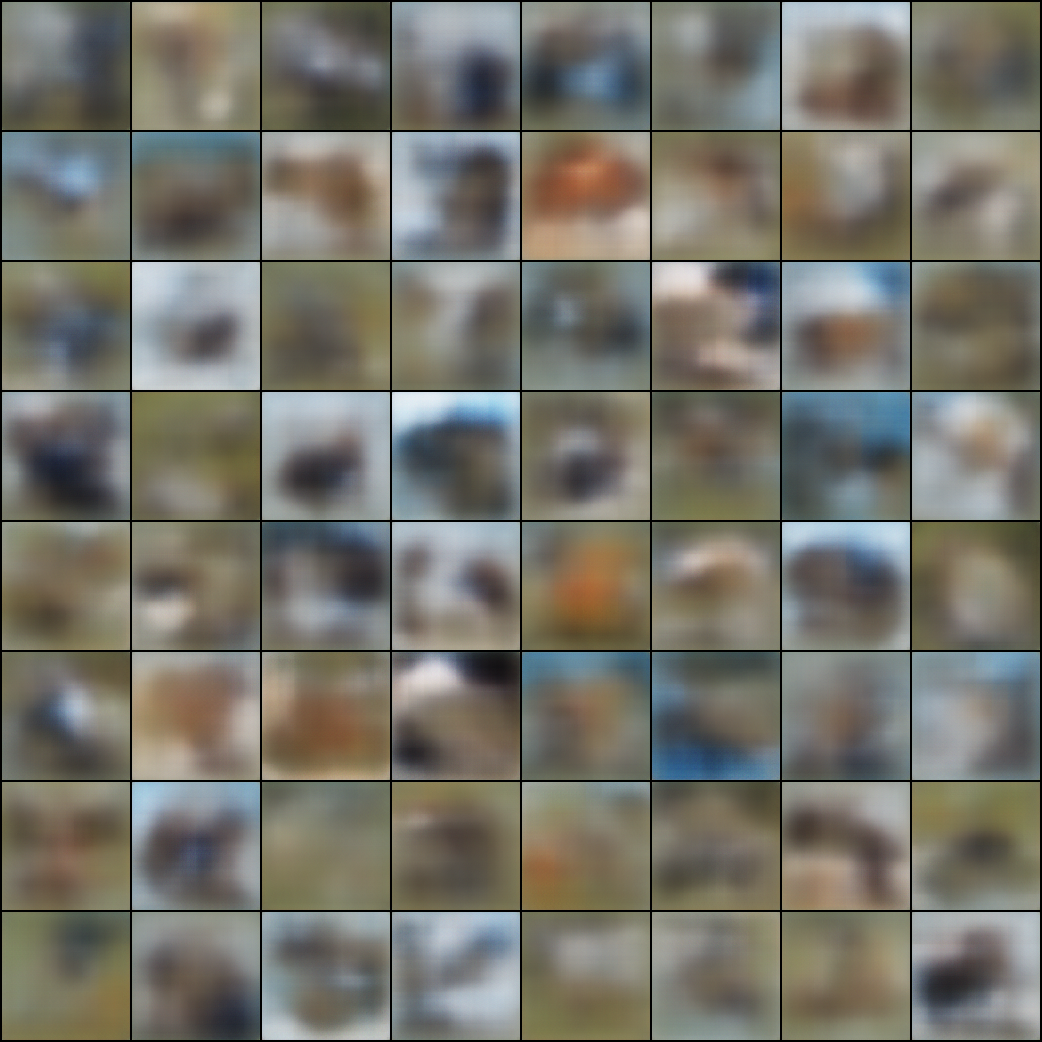